Data Shape: (110, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           110 non-null    int64  
 1   Gender                        110 non-null    int64  
 2   Diabetes                      110 non-null    int64  
 3   Ever smoked                   110 non-null    int64  
 4   PVD                           110 non-null    int64  
 5   CVD                           110 non-null    int64  
 6   Hypercholesterolemia          110 non-null    int64  
 7   RA intimal abnormality        110 non-null    int64  
 8   RA medial calcification       110 non-null    int64  
 9   ITA intimal abnormality       110 non-null    int64  
 10  RA % luminal narrowing        110 non-null    float64
 11  RA  Intimal thickness index   110 non-null    float64
 12  RA Intima-to-media ratio      110 non-null

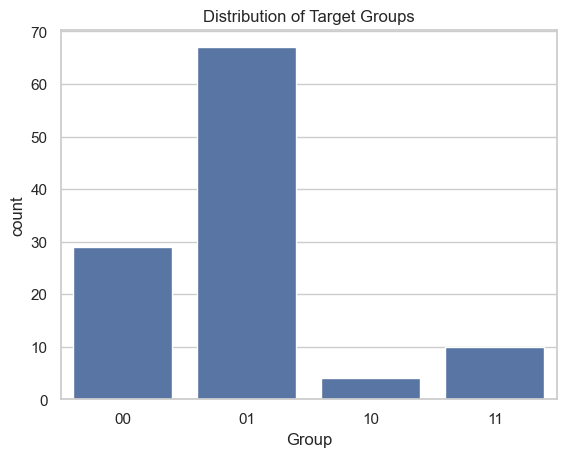

Features shape: (110, 25)
Target shape: (110,)


In [16]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_excel("artery-2.xlsx")

# Display basic information about the dataset
print("Data Shape:", data.shape)
print(data.info())
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Step 2: Fill or drop missing values (for simplicity, fill with mean or mode)
data.fillna(data.mean(numeric_only=True), inplace=True)
for column in data.select_dtypes(include=["object", "category"]).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Step 3: Encode categorical variables
le = LabelEncoder()
for column in ["Gender", "Diabetes", "Ever smoked", "PVD", "CVD", "Hypercholesterolemia"]:
    data[column] = le.fit_transform(data[column])

# Step 4: Define a new target variable combining RA and ITA abnormalities
data["Group"] = (data["RA medial calcification"].astype(str) +
                 data["ITA intimal abnormality"].astype(str))

# Verify the processed data
print("Data after encoding and creating target variable:\n", data.head())

# Step 5: Check the number of each group and display numerically
group_counts = data["Group"].value_counts()
print("Group Counts:\n", group_counts)

# Plot the distribution of the target variable to assess the need for SMOTE
sns.countplot(x="Group", data=data)
plt.title("Distribution of Target Groups")
plt.show()

# Step 6: Define features and target variable for model training
# Exclude 'RA intimal abnormality', 'RA medial calcification', and 'ITA intimal abnormality' from features
features = data.columns.difference(["RA intimal abnormality", "RA medial calcification", "ITA intimal abnormality", "Group"])
X = data[features]
y = data["Group"]

# Display X and y shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)


In [17]:
print("Group Counts:\n", group_counts)

Group Counts:
 Group
01    67
00    29
11    10
10     4
Name: count, dtype: int64


In [23]:
# Import additional libraries for SMOTE and model training
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Apply SMOTE with adjusted k_neighbors to handle small classes
smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display the new class distribution after applying SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

# Proceed with the train-test split, model training, and evaluation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Initialize and train a RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Class distribution after SMOTE:
 Group
00    67
01    67
10    67
11    67
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

          00       0.86      0.95      0.90        19
          01       0.91      0.77      0.83        26
          10       0.93      1.00      0.97        14
          11       0.87      0.91      0.89        22

    accuracy                           0.89        81
   macro avg       0.89      0.91      0.90        81
weighted avg       0.89      0.89      0.89        81

Accuracy Score: 0.8888888888888888


In [35]:
# Import necessary libraries for additional models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define a dictionary of models to train
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "ANN": MLPClassifier(random_state=42, max_iter=500),
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Initialize a list to store results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Capture precision, recall, and F1 for each class
    precision_00 = report["00"]["precision"]
    recall_00 = report["00"]["recall"]
    f1_00 = report["00"]["f1-score"]
    
    precision_01 = report["01"]["precision"]
    recall_01 = report["01"]["recall"]
    f1_01 = report["01"]["f1-score"]
    
    # Add the results to the list
    results.append([model_name, accuracy, precision_00, recall_00, f1_00,
                    precision_01, recall_01, f1_01])

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision (00)", "Recall (00)", "F1-score (00)",
                                            "Precision (01)", "Recall (01)", "F1-score (01)"])

# Display the results table
print(results_df)


c:\Users\Anjaneya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Anjaneya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model  Accuracy  Precision (00)  Recall (00)  F1-score (00)  \
0                  KNN  0.691358        0.666667     0.631579       0.648649   
1                  SVM  0.320988        0.500000     0.052632       0.095238   
2    Gradient Boosting  0.839506        0.850000     0.894737       0.871795   
3        Decision Tree  0.790123        0.842105     0.842105       0.842105   
4                  ANN  0.802469        0.695652     0.842105       0.761905   
5  Logistic Regression  0.703704        0.631579     0.631579       0.631579   
6        Random Forest  0.888889        0.857143     0.947368       0.900000   

   Precision (01)  Recall (01)  F1-score (01)  
0        0.857143     0.461538       0.600000  
1        1.000000     0.192308       0.322581  
2        0.894737     0.653846       0.755556  
3        0.875000     0.538462       0.666667  
4        0.863636     0.730769       0.791667  
5        0.800000     0.615385       0.695652  
6        0.909091     0

In [36]:
# Initialize a list to store results with tuned hyperparameters
tuned_results = []

# Loop through each model and its parameter grid
for model_name, param_grid in param_grids.items():
    model = models[model_name]
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    
    # Fit the model with grid search
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Predict on the test set with the best model
    y_pred = best_model.predict(X_test)
    
    # Calculate accuracy and detailed classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Capture precision, recall, and F1 for each class
    precision_00 = report["00"]["precision"]
    recall_00 = report["00"]["recall"]
    f1_00 = report["00"]["f1-score"]
    
    precision_01 = report["01"]["precision"]
    recall_01 = report["01"]["recall"]
    f1_01 = report["01"]["f1-score"]
    
    precision_10 = report["10"]["precision"]
    recall_10 = report["10"]["recall"]
    f1_10 = report["10"]["f1-score"]
    
    precision_11 = report["11"]["precision"]
    recall_11 = report["11"]["recall"]
    f1_11 = report["11"]["f1-score"]
    
    # Store the best parameters and results
    tuned_results.append([model_name, grid_search.best_params_, accuracy,
                          precision_00, recall_00, f1_00,
                          precision_01, recall_01, f1_01,
                          precision_10, recall_10, f1_10,
                          precision_11, recall_11, f1_11])

# Convert tuned results to a DataFrame for easy visualization
tuned_results_df = pd.DataFrame(tuned_results, columns=["Model", "Best Params", "Accuracy",
                                                        "Precision (00)", "Recall (00)", "F1-score (00)",
                                                        "Precision (01)", "Recall (01)", "F1-score (01)",
                                                        "Precision (10)", "Recall (10)", "F1-score (10)",
                                                        "Precision (11)", "Recall (11)", "F1-score (11)"])

# Display the tuned results table
print(tuned_results_df)


c:\Users\Anjaneya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Anjaneya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model                                        Best Params  \
0                  KNN          {'n_neighbors': 3, 'weights': 'distance'}   
1                  SVM                      {'C': 10, 'kernel': 'linear'}   
2    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
3        Decision Tree  {'criterion': 'gini', 'max_depth': None, 'min_...   
4                  ANN  {'activation': 'tanh', 'hidden_layer_sizes': (...   
5  Logistic Regression       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}   
6        Random Forest  {'max_depth': None, 'min_samples_split': 10, '...   

   Accuracy  Precision (00)  Recall (00)  F1-score (00)  Precision (01)  \
0  0.827160        0.772727     0.894737       0.829268        0.937500   
1  0.888889        0.857143     0.947368       0.900000        1.000000   
2  0.839506        0.850000     0.894737       0.871795        0.894737   
3  0.814815        0.842105     0.842105       0.842105        0.888889   
4  0.864

In [41]:
# Assuming 'tuned_results_df' is the DataFrame from your previous results

# Select the best model based on maximum accuracy
best_model_info = tuned_results_df.loc[tuned_results_df["Accuracy"].idxmax()]
best_model_name = best_model_info["Model"]
best_params = best_model_info["Best Params"]

# Initialize the best model with the best parameters
best_model = models[best_model_name].set_params(**best_params)

# Train the best model on the training set
best_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate accuracy
final_accuracy = accuracy_score(y_test, y_test_pred)

# Generate a detailed classification report
final_report = classification_report(y_test, y_test_pred)

# Display the results
print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_params}")
print(f"Final Model Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:\n", final_report)


Best Model: SVM
Best Parameters: {'C': 10, 'kernel': 'linear'}
Final Model Accuracy: 0.8889

Classification Report:
               precision    recall  f1-score   support

          00       0.86      0.95      0.90        19
          01       1.00      0.69      0.82        26
          10       0.88      1.00      0.93        14
          11       0.85      1.00      0.92        22

    accuracy                           0.89        81
   macro avg       0.89      0.91      0.89        81
weighted avg       0.90      0.89      0.88        81



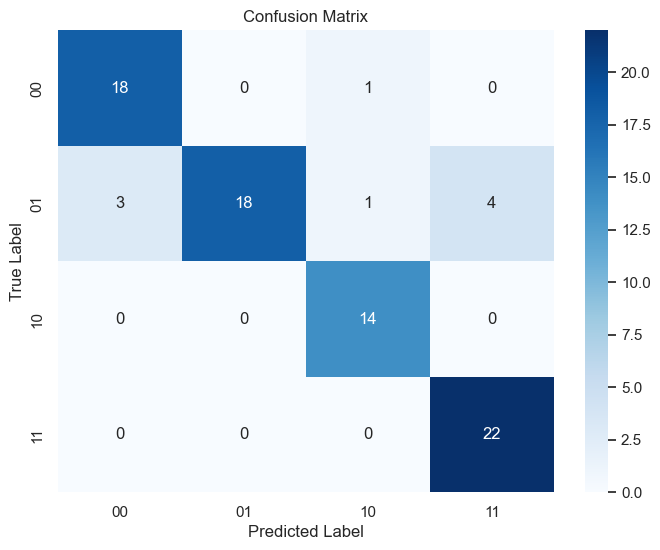

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


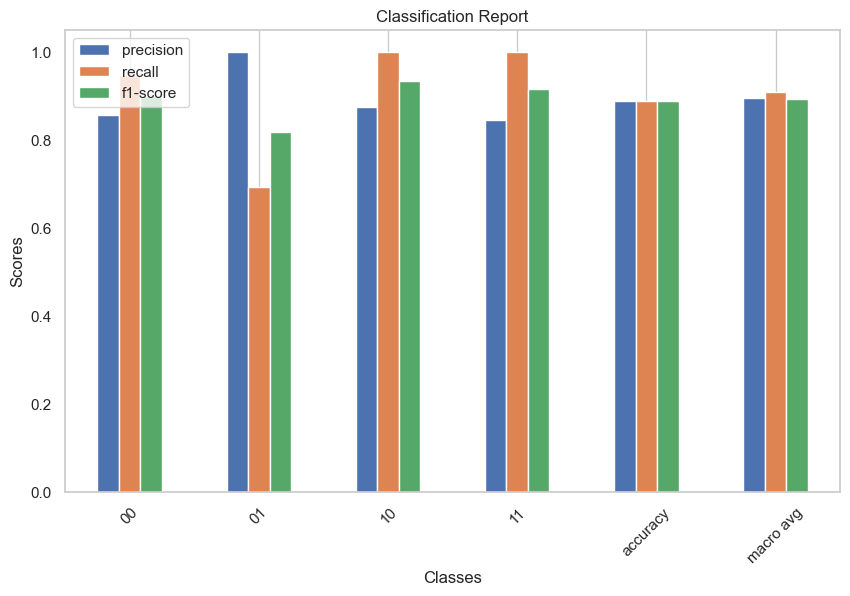

In [81]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate a classification report
report = classification_report(y_test, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report
report_df[:-1][['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


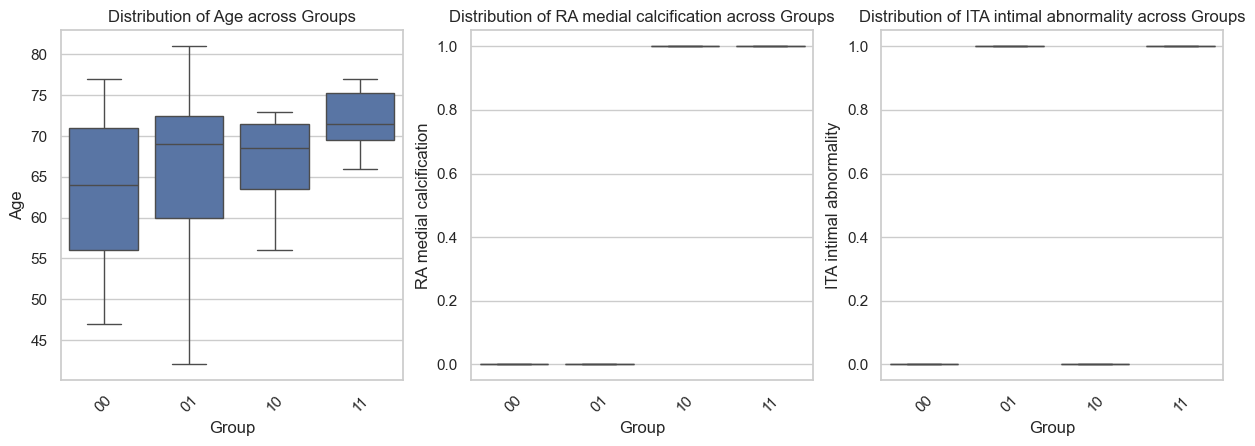

In [64]:
# Set the size of the plot
plt.figure(figsize=(15, 10))

# Box plots for continuous variables
continuous_vars = ["Age", "RA medial calcification", "ITA intimal abnormality"]  
for i, var in enumerate(continuous_vars):
    plt.subplot(2, len(continuous_vars), i + 1)
    sns.boxplot(x='Group', y=var, data=data)
    plt.title(f'Distribution of {var} across Groups')
    plt.xticks(rotation=45)


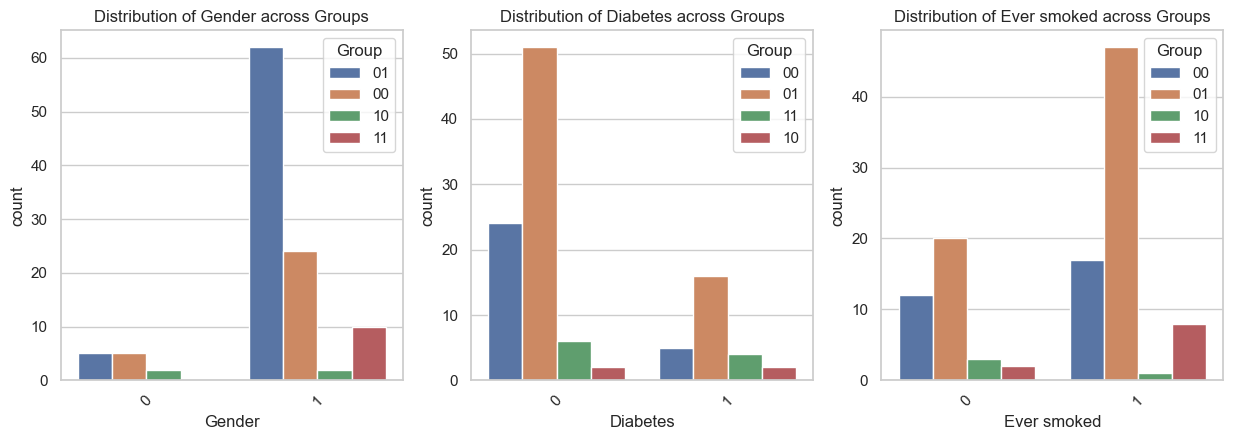

In [78]:
plt.figure(figsize=(15, 10))
# Count plots for categorical variables
categorical_vars = ["Gender", "Diabetes", "Ever smoked"]
for i, var in enumerate(categorical_vars):
    plt.subplot(2, len(categorical_vars), len(continuous_vars) + i + 1)
    sns.countplot(x=var, hue='Group', data=data)
    plt.title(f'Distribution of {var} across Groups')
    plt.xticks(rotation=45)

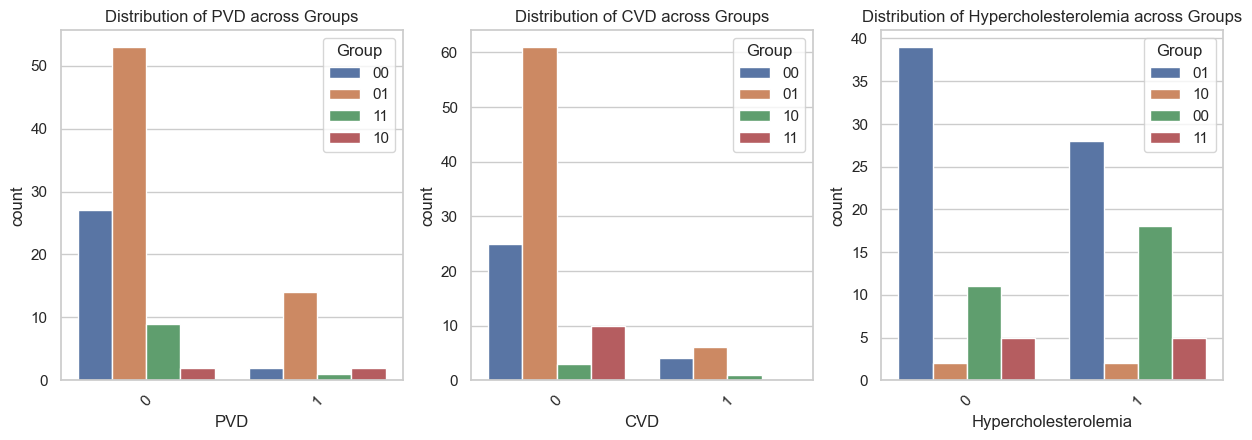

In [79]:
plt.figure(figsize=(15, 10))
# Count plots for categorical variables
categorical_vars = ["PVD", "CVD", "Hypercholesterolemia"]
for i, var in enumerate(categorical_vars):
    plt.subplot(2, len(categorical_vars), len(continuous_vars) + i + 1)
    sns.countplot(x=var, hue='Group', data=data)
    plt.title(f'Distribution of {var} across Groups')
    plt.xticks(rotation=45)